In [1]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle

Could not check jupyter-widgets extensions.
Traceback (most recent call last):
  File "C:\conda\Lib\site-packages\solara\checks.py", line 201, in check_jupyter
    python_executable = server_python or get_server_python_executable(silent)
                                         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^
  File "C:\conda\Lib\site-packages\solara\checks.py", line 155, in get_server_python_executable
    pythons = [getcmdline(server["pid"]) for server in servers]
               ~~~~~~~~~~^^^^^^^^^^^^^^^
  File "C:\conda\Lib\site-packages\solara\checks.py", line 135, in getcmdline
    return subprocess.check_output(["wmic", "process", "get", "commandline", "/format:list"]).split(b"\n")[0].split(b" ")[0].decode("utf-8")
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\conda\Lib\subprocess.py", line 472, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
           ~~~^^^^^^^^^^^^^^^^^^^^^^^^

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        """initialize a MoneyAgent instance.

        Args:
            model: A model instance
        """
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        """Move the agent to a random neighboring cell."""
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        """Give 1 unit of wealth to a random agent in the same cell."""
        cellmates = [a for a in self.cell.agents if a is not self]

        if cellmates:  # Only give money if there are other agents present
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        """do one step of the agent."""
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n=10, width=10, height=10, seed=None):
        """Initialize a MoneyModel instance.

        Args:
            N: The number of agents.
            width: width of the grid.
            height: Height of the grid.
        """
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Create agents
        MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        self.datacollector.collect(self)

    def step(self):
        """do one step of the model"""
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

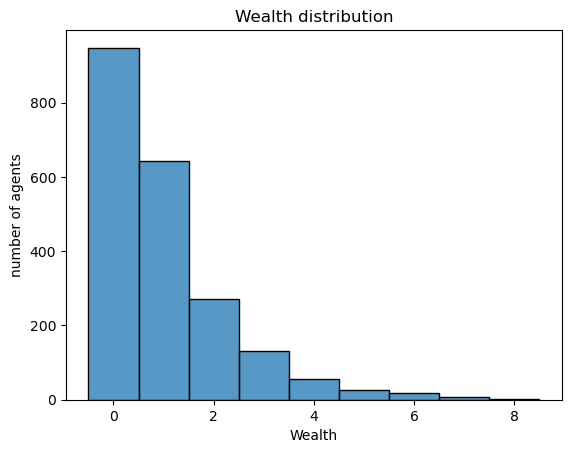

In [3]:
# Lets make sure the model works
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn
g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [4]:
def agent_portrayal(agent):
    portrayal = AgentPortrayalStyle(size=50, color="tab:orange")
    if agent.wealth > 0:
        portrayal.update(("color", "tab:blue"), ("size", 100))
    return portrayal

In [5]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

Cannot show ipywidgets in text

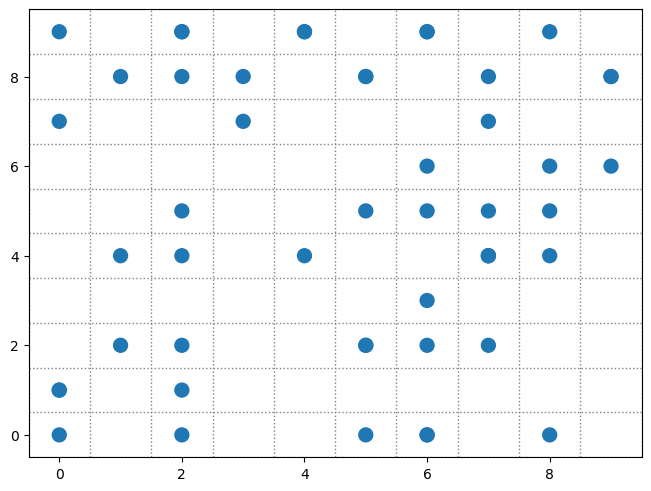

In [6]:
# Create initial model instance
money_model = MoneyModel(n=50, width=10, height=10)
renderer = SpaceRenderer(model=money_model, backend="matplotlib").render(
    agent_portrayal=agent_portrayal
)

GiniPlot = make_plot_component("Gini")

page = SolaraViz(
    money_model,
    renderer,
    components=[GiniPlot],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)
# This is required to render the visualization in the Jupyter notebook
page